# Setup

In [1]:
%matplotlib inline

import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import pickle

from dotenv import find_dotenv, load_dotenv

In [2]:
load_dotenv(find_dotenv())
repo_dir = os.environ['REPO_DIR']
output_images_dir = os.path.join(repo_dir, 'output_images')

In [3]:
img_path = os.path.join(repo_dir, 'output_images', 'test1.jpg')
img = mpimg.imread(img_path)

# Examples from class notes

In [4]:
def example_1(img):
    # example #1 from course notes #30

    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    # Plotting thresholded images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Stacked thresholds')
    ax1.imshow(color_binary, cmap='gray')

    ax2.set_title('Combined S channel and gradient thresholds')
    ax2.imshow(combined_binary, cmap='gray')

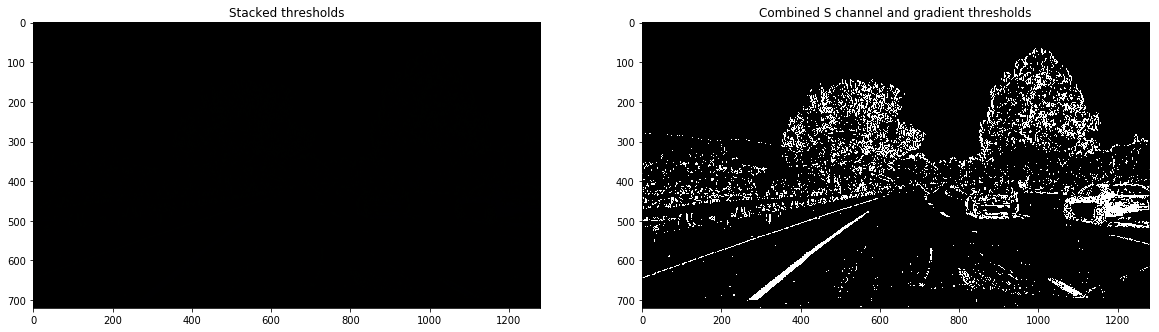

In [5]:
example_1(np.copy(img))

In [6]:
# example code #2 from course notes #30

# Edit this function to create your own pipeline.
def pipeline(img, colour_space, channel, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    
    # Convert to HSV color space and separate the V channel
    img = cv2.cvtColor(img, colour_space).astype(np.float)
    channel = img[:, :, channel]
    
    # Sobel x
    sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(channel)
    s_binary[(channel >= s_thresh[0]) & (channel <= s_thresh[1])] = 1
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, combined_binary

In [7]:
def example_2(img, channel=2):
    # change colour spaced and channel to ensure best result
    colour_space = cv2.COLOR_RGB2HLS
    color_binary, combined_binary = pipeline(img, colour_space, channel)

    # plot the result
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(img)
    ax1.set_title('Original', fontsize=20)

    ax2.imshow(color_binary)
    ax2.set_title('Stacked', fontsize=20)

    ax3.imshow(combined_binary, cmap='gray')
    ax3.set_title('Combined', fontsize=20)

    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.) 

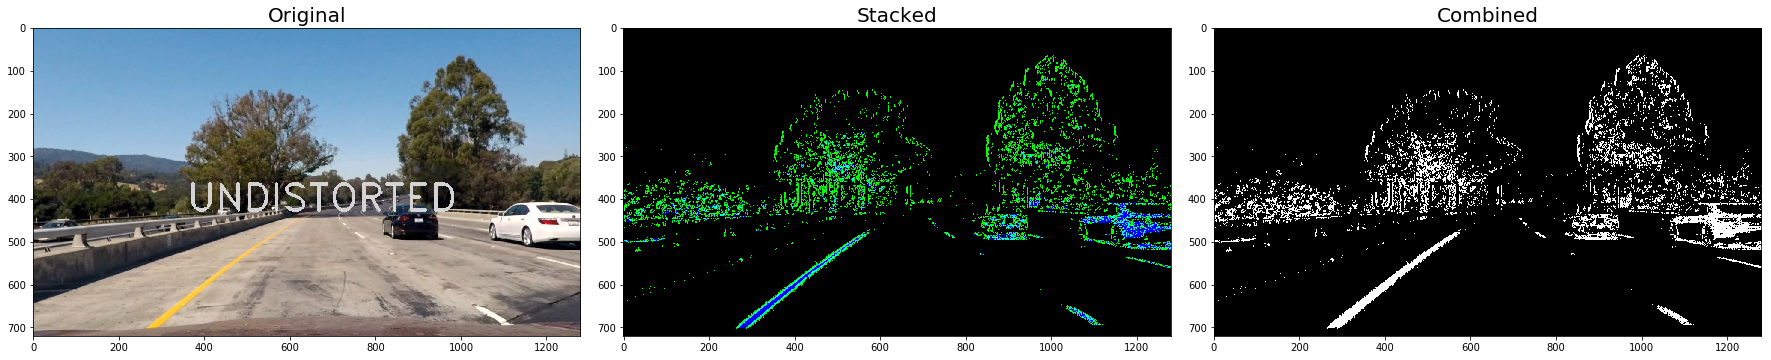

In [8]:
example_2(np.copy(img), channel=2)

# Combining thresholds

## `binary_threshold()`

In [9]:
def binary_threshold(img, thresh):
    """Return binary threshold image for further processing

    Create a mask of 1's where the pixel value is:
        - thresh_min < x < thresh_max
        - thresh[0] < x < thresh[1]

    Args:
        img (image): the sobel image to apply the transform to

        thresh (tuple): (lower_bound, upper_bound)
                        lower_bound = lower bound for determining output
                        upper_bound = upper bound for determining output

    Returns:
        image: binary threshold image
    """
    binary_output = np.zeros_like(img)
    binary_output[(img > thresh[0]) & (img <= thresh[1])] = 1
    return binary_output

## `abs_sobel_thresh()`

In [10]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """Return absolute sobel threshold image for further processing

    Steps taken
        1) Take the derivative in x or y given orient = 'x' or 'y'
        2) Take the absolute value of the derivative or gradient
        3) Scale to 8-bit (0 - 255) then convert to type = np.uint8
        4) Create a mask of 1's where the scaled gradient magnitude
                is > thresh_min and < thresh_max

    Args:
        img (image): the image to apply the transform to

        orient (str): One of ['x', 'y'] axis to apply sobel operator to
        
        sobel_kernel (int): (default=3) region to apply magnitude over

        thresh (tuple): (lower_bound, upper_bound)
                        lower_bound = lower bound for determining output
                        upper_bound = upper bound for determining output

    Returns:
        image: binary threshold image
    """
    # 1
    if orient == 'x':
        sobel = cv2.Sobel(np.copy(img), cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(np.copy(img), cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 2
    sobel = np.absolute(sobel)

    # 3
    sobel = np.uint8(255 * sobel / np.max(sobel))

    # 4
    binary_output = binary_threshold(sobel, thresh)

    return binary_output

## `mag_thresh()`

In [11]:
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    """Apply a threshold to the overall magnitude of the gradient

    Steps taken
        1) Take the gradient in x and y separately
        2) Calculate the magnitude
        3) Scale to 8-bit (0 - 255) and convert to type = np.uint8
        4) Create a binary mask where mag thresholds are met

    Args:
        img (image): the image to apply the transform to

        sobel_kernel (int): (default=3) region to apply magnitude over

        thresh (tuple): (lower_bound, upper_bound)
                        lower_bound = lower bound for determining output
                        upper_bound = upper bound for determining output

    Returns:
        image: binary threshold image
    """
    # 1
    sobelx = cv2.Sobel(np.copy(img), cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(np.copy(img), cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 2
    sobel = np.sqrt(sobelx ** 2 + sobely ** 2)

    # 3
    scale_factor = np.max(sobel) / 255
    sobel = (sobel / scale_factor).astype(np.uint8)

    # 4
    binary_output = binary_threshold(sobel, thresh)

    return binary_output

## `dir_threshold()`

In [12]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi / 2)):
    """
    Apply the following steps to img
        1) Take the gradient in x and y separately
        2) Take the absolute value of the x and y gradients
        3) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
        4) Create a binary mask where direction thresholds are met

    Args:
        img (image): the image to apply the transform to

        sobel_kernel (int): (default=3) region to apply magnitude over

        thresh (tuple): (lower_bound, upper_bound)
                        lower_bound = lower bound for determining output
                        upper_bound = upper bound for determining output

    Returns:
        image: binary threshold image
    """
    # 1
    sobelx = cv2.Sobel(np.copy(img), cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(np.copy(img), cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 2 & 3
    sobel = np.arctan2(np.absolute(sobely), np.absolute(sobelx))

    # 5
    binary_output = binary_threshold(sobel, thresh)

    return binary_output

# `sobel_image()`

In [13]:
def sobel_image(img_to_process, ksize, thresh, image_name):
    gradx = abs_sobel_thresh(img_to_process, orient='x', sobel_kernel=ksize, thresh=thresh)
    grady = abs_sobel_thresh(img_to_process, orient='y', sobel_kernel=ksize, thresh=thresh)
    magnitude = mag_thresh(img_to_process, sobel_kernel=ksize, thresh=thresh)
    direction = dir_threshold(img_to_process, sobel_kernel=ksize, thresh=(0, np.pi/4))

    combined = np.zeros_like(direction)
    combined[((gradx == 1) & (grady==1)) | ((magnitude == 1) & (direction == 1))] = 1

    subtitles = [image_name, 'Grad-X', 'Grad-Y', 'Magnitude', 'Direction', 'Combined']
    grads = [img_to_process, gradx, grady, magnitude, direction, combined]

    fig, axes = plt.subplots(1, len(grads), figsize=(20, 10))
    for i, (subtitle, grad) in enumerate(zip(subtitles, grads)):
        axes[i].imshow(grad, cmap='gray')
        axes[i].set_title(subtitle)

    plt.show()

# `process_image()`

In [14]:
def process_image(img_to_process, ksize, thresh, colour_channel, c1_thresh, c2_thresh, c3_thresh):
    # locals
    subtitles = [c for c in colour_channel]
    channel_thresholds = [c1_thresh, c2_thresh, c3_thresh]
    
    # sobel
    sobel_image(img_to_process, ksize, thresh, colour_channel)
    for i, subtitle in enumerate(subtitles):
        sobel_image(img_to_process[:, :, i], ksize, thresh, subtitle)

    # colour channel binary plots
    fig, axes = plt.subplots(1, img_to_process.shape[2], figsize=(20, 10))
    for i, (subtitle, channel_threshold) in enumerate(zip(subtitles, channel_thresholds)):
        axes[i].imshow(binary_threshold(img_to_process[:,:,i], channel_threshold), cmap='gray')
        axes[i].set_title(subtitle)

    plt.show()
    plt.close(fig)

In [15]:
# set images
rgb = np.copy(img)
gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
hls = cv2.cvtColor(rgb, cv2.COLOR_RGB2HLS)
hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)

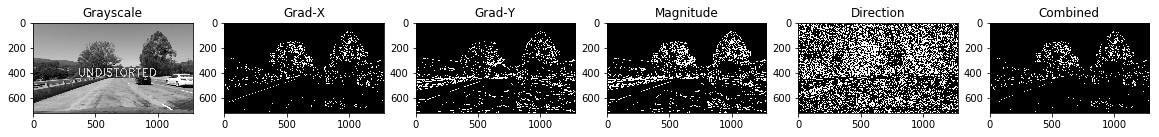

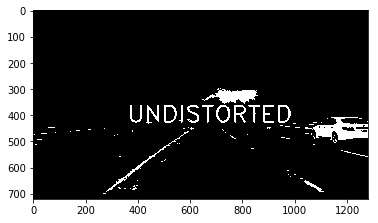

In [16]:
# grayscale
ksize=3
thresh=(20, 100)
sobel_image(gray, ksize, thresh, 'Grayscale')
plt.imshow(binary_threshold(gray, (200, 255)), cmap='gray')

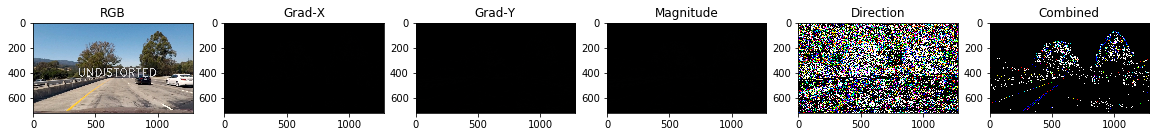

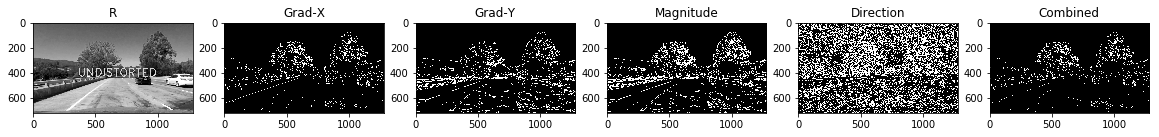

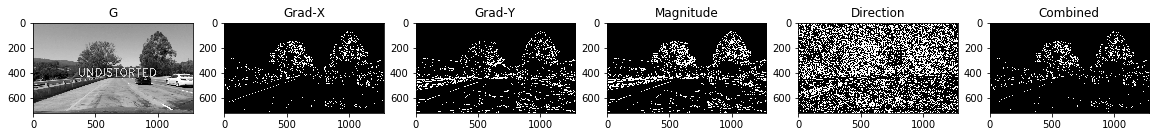

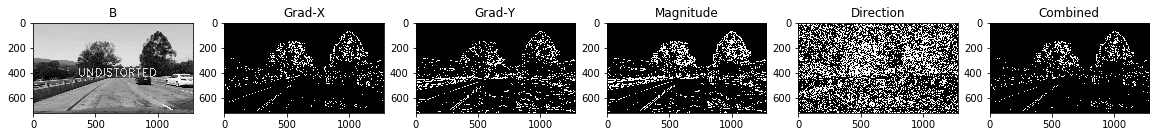

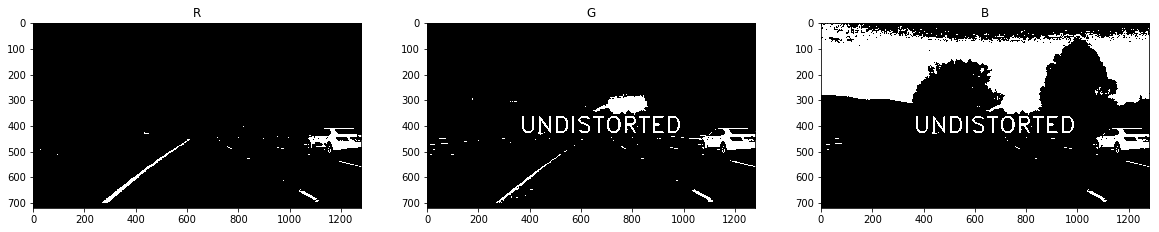

In [17]:
# RGB
img_to_process = rgb
ksize=3
colour_channel = 'RGB'
thresh = (20, 100)
c1_thresh = (225, 255)
c2_thresh = (200, 255)
c3_thresh = (200, 255)

process_image(img_to_process, ksize, thresh, colour_channel, c1_thresh, c2_thresh, c3_thresh)

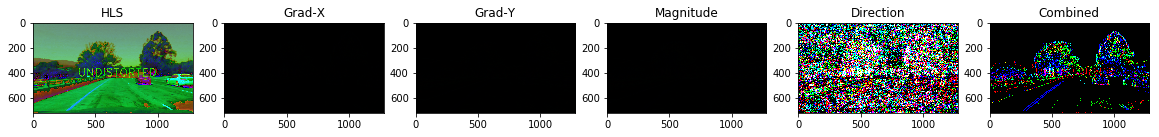

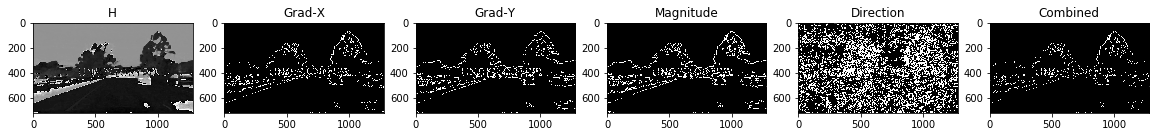

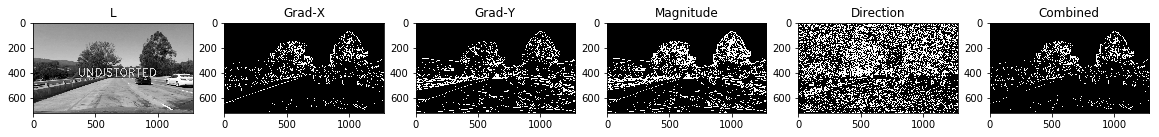

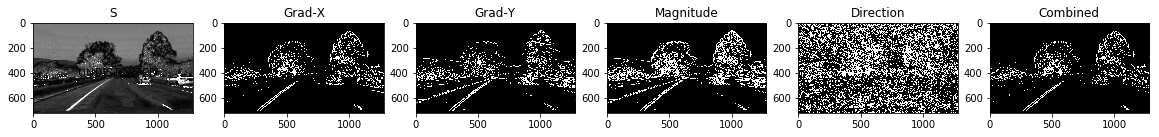

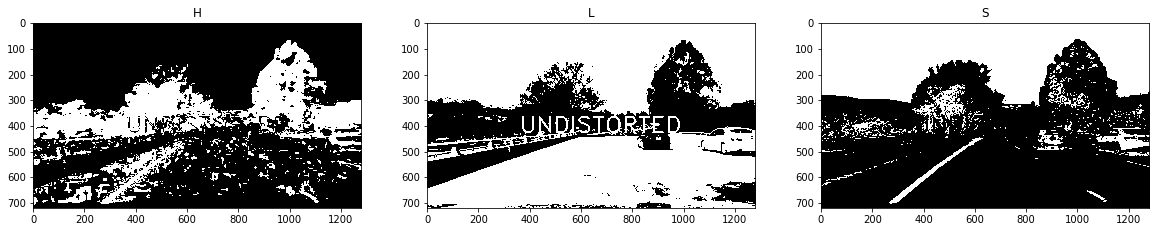

In [18]:
# HLS
img_to_process = hls
ksize=7
colour_channel = 'HLS'
thresh = (20, 100)
c1_thresh = (15, 100)
c2_thresh = (100, 255)
c3_thresh = (90, 255)

process_image(img_to_process, ksize, thresh, colour_channel, c1_thresh, c2_thresh, c3_thresh)

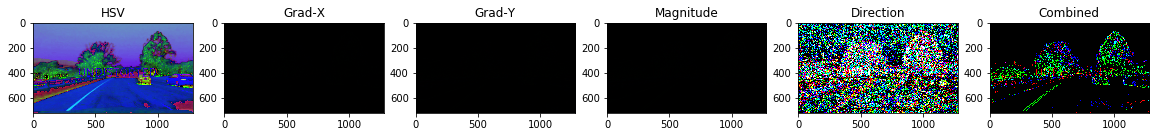

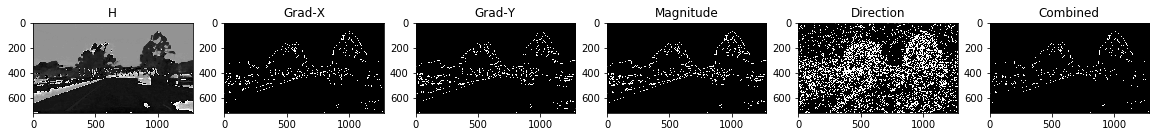

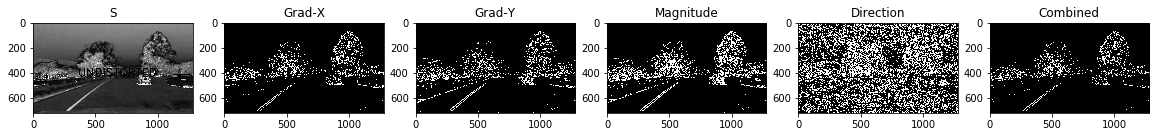

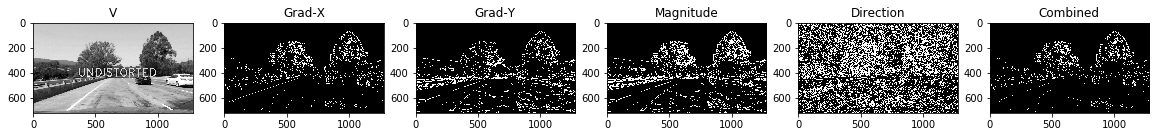

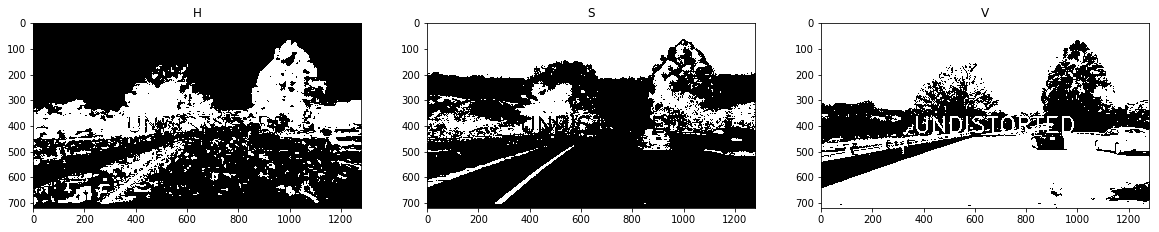

In [19]:
# HSV
img_to_process = hsv
ksize=3
colour_channel = 'HSV'
thresh = (20, 100)
c1_thresh = (15, 100)
c2_thresh = (90, 255)
c3_thresh = (90, 255)

process_image(img_to_process, ksize, thresh, colour_channel, c1_thresh, c2_thresh, c3_thresh)

# Combine colour and gradient

In [20]:
# combine colour binary thresholds
r = binary_threshold(rgb[:, :, 0], (225, 255))
s = binary_threshold(hls[:, :, 2], (170, 255))
gray = binary_threshold(cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY), (215, 255))

rs_combined = np.zeros_like(r)
rs_combined[((r == 1) | (s==1))] = 1

rgray_combined = np.zeros_like(r)
rgray_combined[((r == 1) | (gray == 1))] = 170

rsgray_combined = np.zeros_like(r)
rsgray_combined[((r == 1) | (s==1) | (gray == 1))] = 1

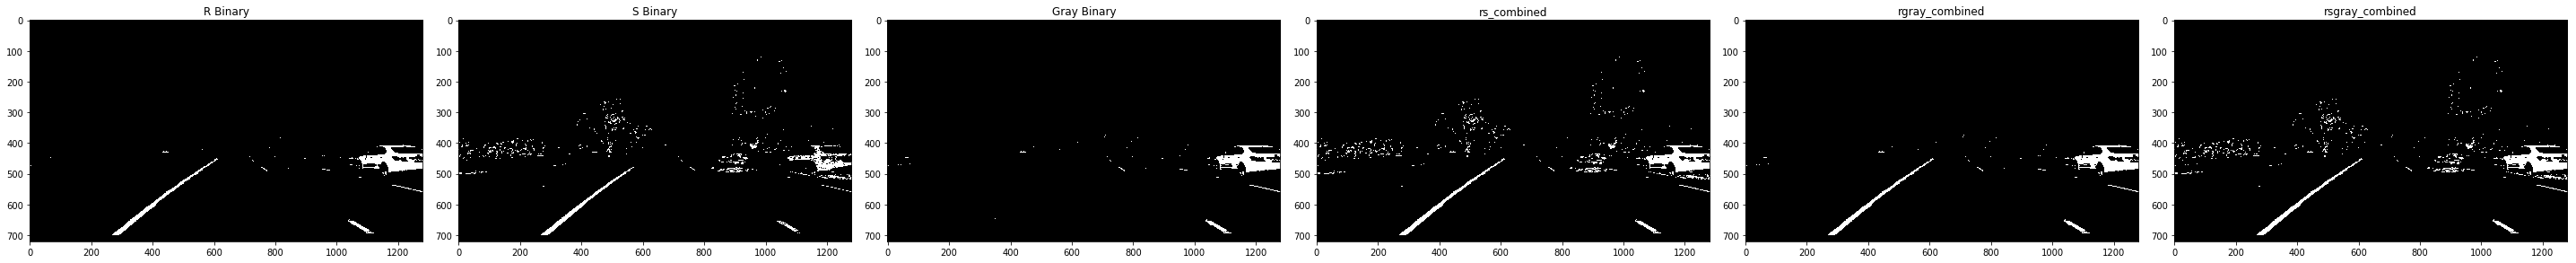

In [21]:
# build plot of combined colour binary thresholds
fig, axes = plt.subplots(1, 6, figsize=(40, 20))

axes[0].set_title('R Binary')
axes[0].imshow(r, cmap='gray')

axes[1].set_title('S Binary')
axes[1].imshow(s, cmap='gray')

axes[2].set_title('Gray Binary')
axes[2].imshow(gray, cmap='gray')

axes[3].set_title('rs_combined')
axes[3].imshow(rs_combined, cmap='gray')

axes[4].set_title('rgray_combined')
axes[4].imshow(rgray_combined, cmap='gray')

axes[5].set_title('rsgray_combined')
axes[5].imshow(rsgray_combined, cmap='gray')

plt.tight_layout()
plt.show()
plt.close(fig)

# Source code

In [22]:
def binary_threshold(img, thresh):
    """Return binary threshold image for further processing

    Create a mask of 1's where the pixel value is:
        - thresh_min < x < thresh_max
        - thresh[0] < x < thresh[1]

    Args:
        img (image): the sobel image to apply the transform to

        thresh (tuple): (lower_bound, upper_bound)
                        lower_bound = lower bound for determining output
                        upper_bound = upper bound for determining output

    Returns:
        image: binary threshold image
    """
    binary_output = np.zeros_like(img)
    binary_output[(img > thresh[0]) & (img <= thresh[1])] = 1
    return binary_output

In [23]:
def abs_sobel_thresh(sobel, thresh=(20, 100)):
    """Return absolute sobel threshold image for further processing

    Steps taken
        1) Take the absolute value of the sobel image(derivative or gradient)
        2) Scale to 8-bit (0 - 255) then convert to type = np.uint8
        3) Create a binary mask where thresholds are met

    Args:
        sobel (image): the sobel image to apply the transform to

        thresh (tuple): (lower_bound, upper_bound)
                        lower_bound = lower bound for determining output
                        upper_bound = upper bound for determining output

    Returns:
        image: binary threshold image
    """
    sobel = np.absolute(sobel)
    sobel = np.uint8(255 * sobel / np.max(sobel))
    return binary_threshold(sobel, thresh)

In [24]:
def mag_thresh(x_sobel, y_sobel, thresh=(0, 255)):
    """Apply a threshold to the overall magnitude of the gradient

    Steps taken
        1) Calculate the magnitude
        2) Scale to 8-bit (0 - 255) and convert to type = np.uint8
        3) Create a binary mask where thresholds are met

    Args:
        x_sobel (image): sobel image of gradients across the x axis
        
        y_sobel (image): sobel image of gradients across the y axis

        thresh (tuple): (lower_bound, upper_bound)
                        lower_bound = lower bound for determining output
                        upper_bound = upper bound for determining output

    Returns:
        image: binary threshold image
    """
    sobel = np.sqrt(x_sobel ** 2 + y_sobel ** 2)
    scale_factor = np.max(sobel) / 255
    sobel = (sobel / scale_factor).astype(np.uint8)
    return binary_threshold(sobel, thresh)

In [25]:
def dir_threshold(x_sobel, y_sobel, thresh=(0, np.pi / 4)):
    """Apply direction threshold
    Steps taken:
        1) Take the absolute value of the x and y gradients
        2) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
        3) Create a binary mask where thresholds are met

    Args:
        x_sobel (image): sobel image of gradients across the x axis
        
        y_sobel (image): sobel image of gradients across the y axis

        thresh (tuple): (lower_bound, upper_bound)
                        lower_bound = lower bound for determining output
                        upper_bound = upper bound for determining output

    Returns:
        image: binary threshold image
    """
    sobel = np.arctan2(np.absolute(y_sobel), np.absolute(x_sobel))
    return binary_threshold(sobel, thresh)

In [26]:
def combined_binary(img, ksize=3):
    # ---------------------------------------------------------
    # Colour binary
    # set images
    rgb = np.copy(img)
#     gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(rgb, cv2.COLOR_RGB2HLS)

    # combine colour binary thresholds
    r_binary = binary_threshold(rgb[:, :, 0], (225, 255))
    s_binary = binary_threshold(hls[:, :, 2], (170, 255))
#     gray_binary = binary_threshold(gray, (215, 255))

    colour_binary = np.zeros_like(r_binary)
#     colour_binary[((r_binary == 1) |
#                    (s_binary==1) |
#                    (gray_binary == 1))] = 1
    colour_binary[((r_binary == 1) |
                   (s_binary==1))] = 1
    
    # ---------------------------------------------------------
    # Sobel binary
    # set sobels
    channel = hls[:, :, 2]

    x_sobel = cv2.Sobel(channel, cv2.CV_64F, 1, 0, ksize=ksize)
#     y_sobel = cv2.Sobel(channel, cv2.CV_64F, 0, 1, ksize=ksize)

    # get abs_sobel
    x_abs_sobel = abs_sobel_thresh(x_sobel, thresh=(20, 100))
#     y_abs_sobel = abs_sobel_thresh(y_sobel, thresh=(20, 100))
    
    # get mag_sobel
#     mag_sobel = mag_thresh(x_sobel, y_sobel, thresh=(20, 100))
    
    # get dir_sobel
#     dir_sobel = dir_threshold(x_sobel, y_sobel, thresh=(0, np.pi / 4)) 

#     sobel_binary = np.zeros_like(channel)
#     sobel_binary[((x_abs_sobel == 1) & (y_abs_sobel==1)) |
#                  ((mag_sobel == 1) & (dir_sobel== 1))] = 1
    sobel_binary = x_abs_sobel
    
    # ---------------------------------------------------------
    # Combined binary
    combined_binary = np.zeros_like(r)
    combined_binary[((colour_binary == 1) |
                     (sobel_binary==1))] = 1
    
    return colour_binary, sobel_binary, combined_binary

In [27]:
def plot_binary(img, colour_binary, sobel_binary, binary_img):
    fig, axes = plt.subplots(1, 4, figsize=(40, 30))

    axes[0].set_title('img')
    axes[0].imshow(img)

    axes[1].set_title('colour_binary')
    axes[1].imshow(colour_binary, cmap='gray')

    axes[2].set_title('sobel_binary')
    axes[2].imshow(sobel_binary, cmap='gray')

    axes[3].set_title('binary_img')
    axes[3].imshow(binary_img, cmap='gray')
    
    plt.show()
    plt.close(fig)

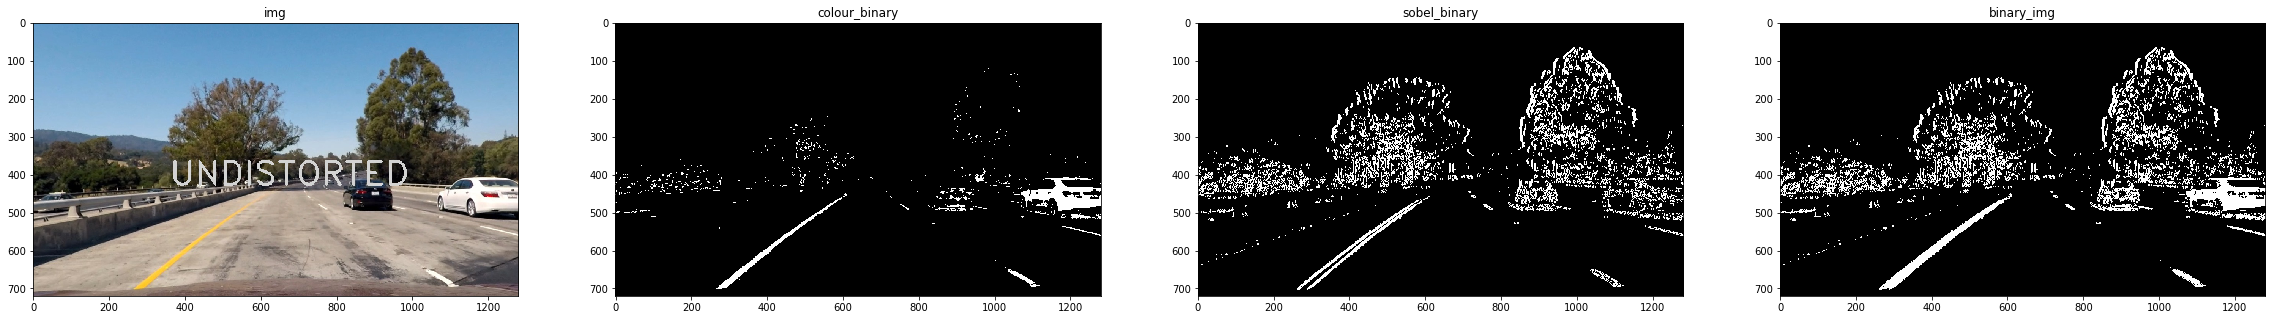

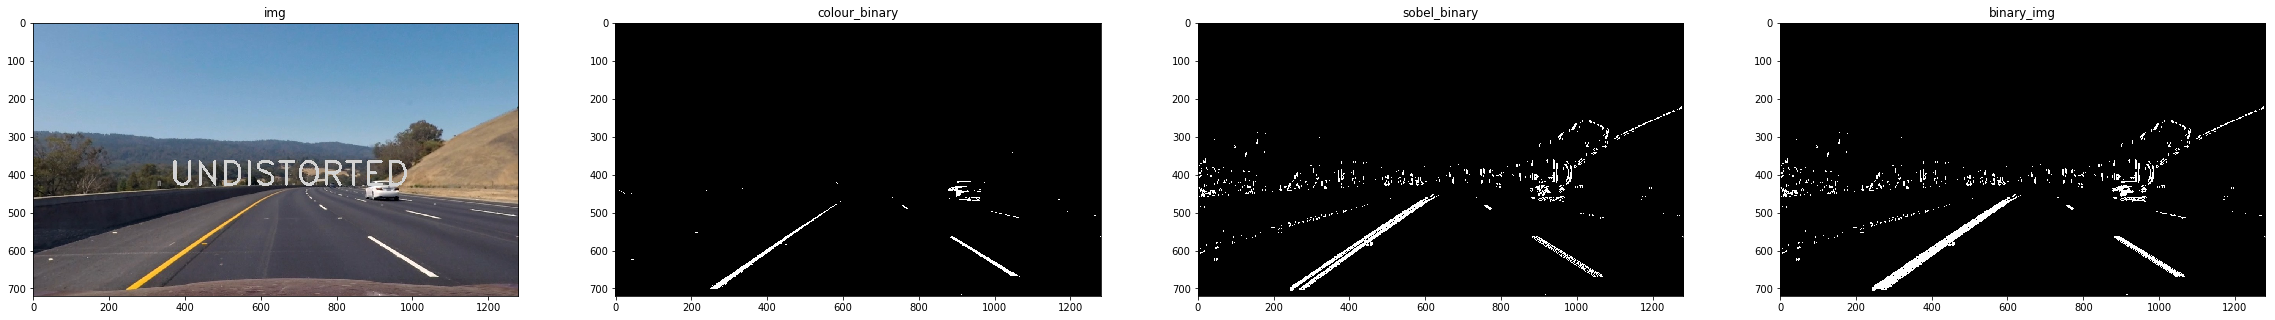

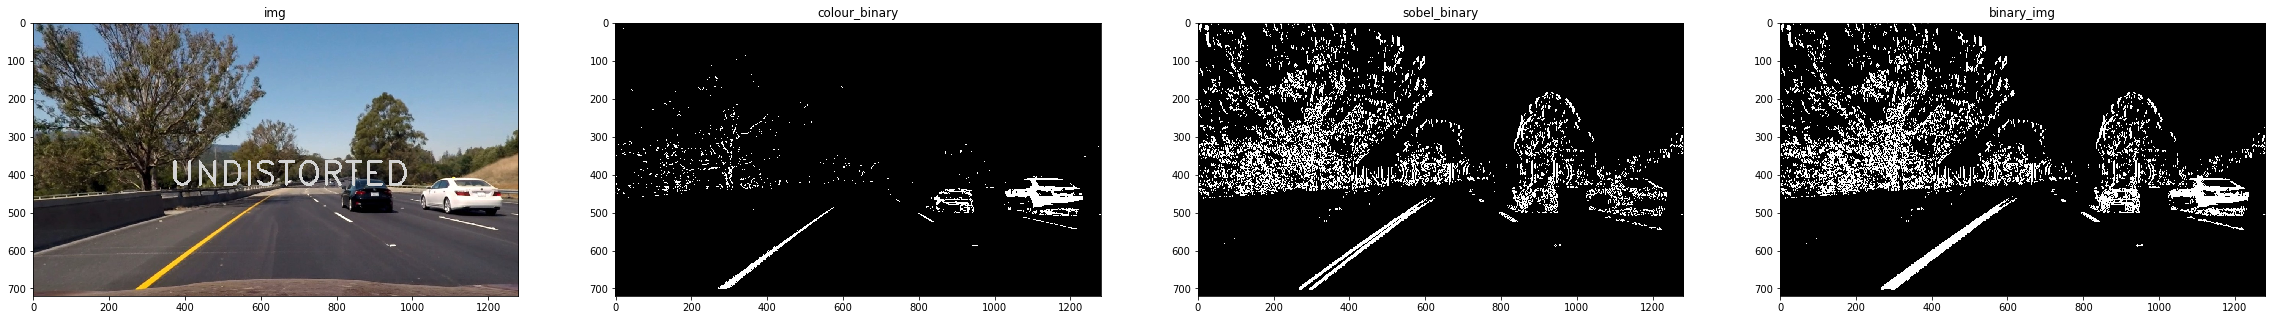

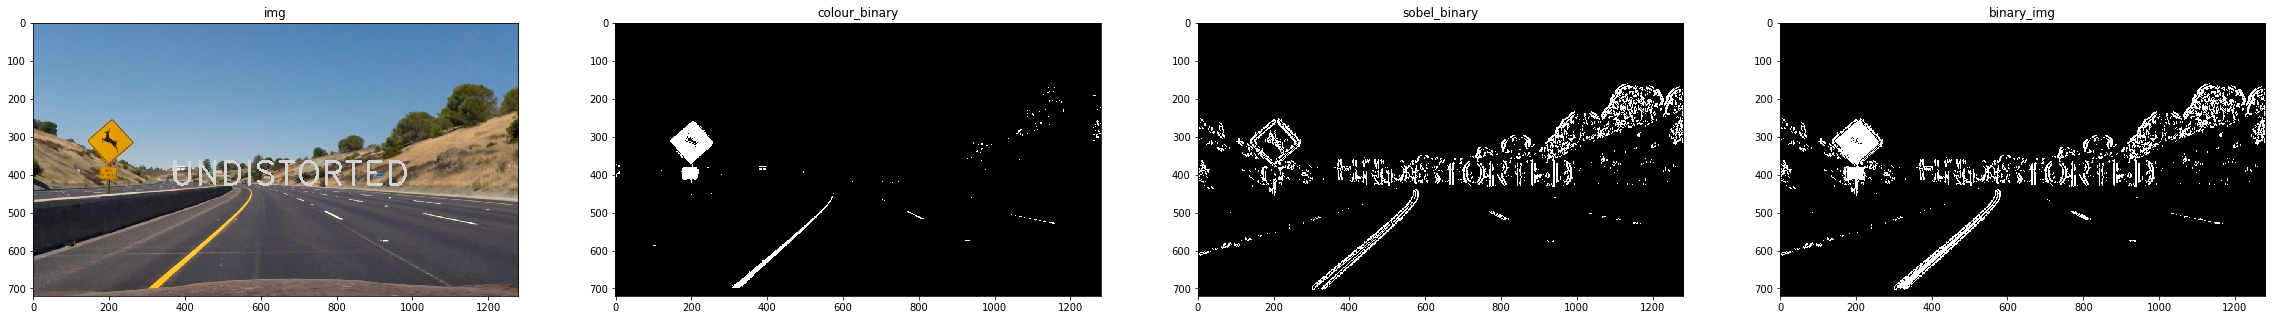

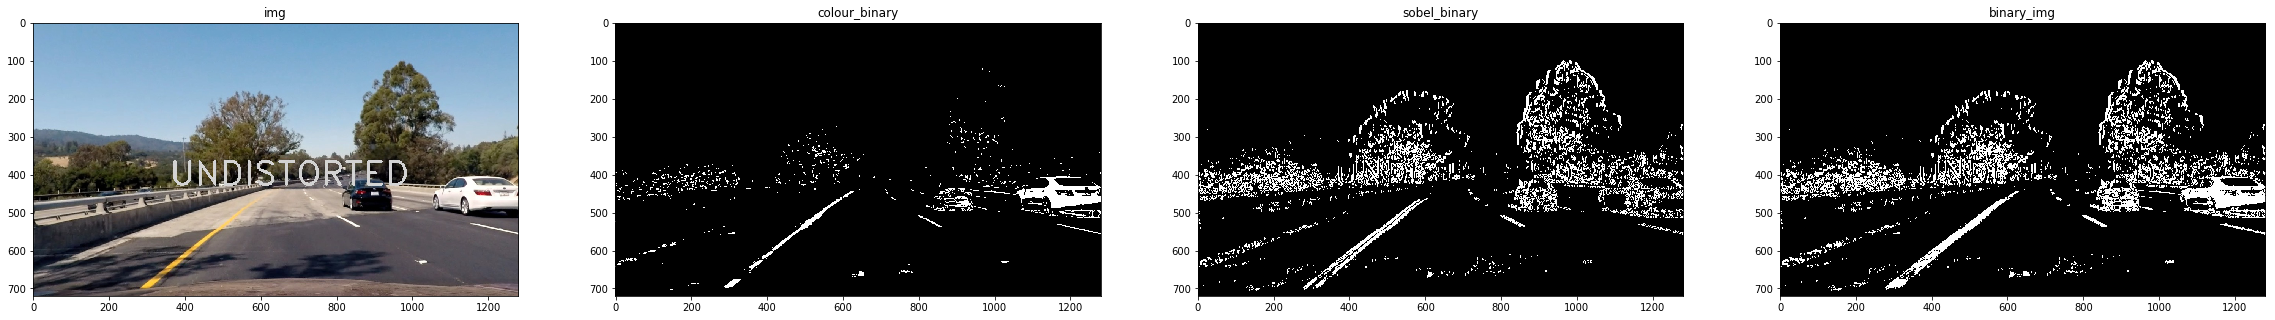

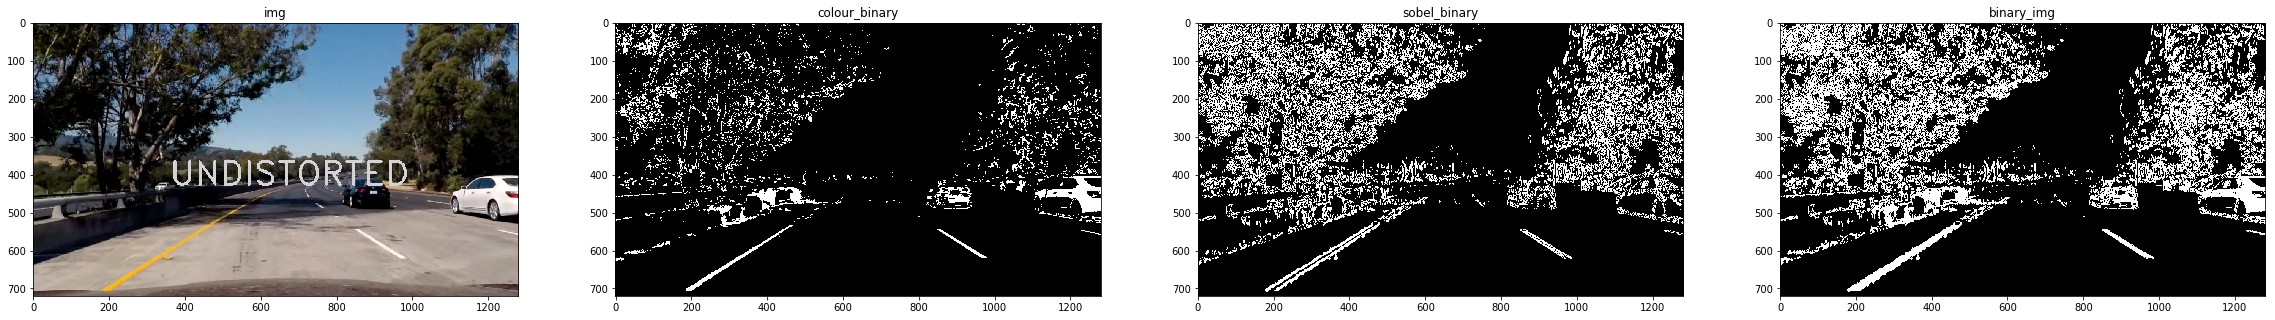

In [28]:
for path in glob.iglob(os.path.join(output_images_dir, './test[1-6].jpg')):
    img = mpimg.imread(path)
    colour_binary, sobel_binary, binary_img = combined_binary(img, ksize=9)
    plot_binary(img, colour_binary, sobel_binary, binary_img)

In [29]:
def undistort_img(img, M, dist):
    """Un-distorts image on disk

    Args:
        img_path (str): Path to image to undistort

        M (numpy.array): Camera matrix (output from cv2.calibrateCamera())

        dist (numpy.array): Distortion coefficients (output from
                            cv2.calibrateCamera())

    Returns
        image: numpy.array representation of an image

    """
    return cv2.undistort(img, M, dist, None, M)

def get_perspective_matrices():
    src_list = [(200, 720), (570, 470), (720, 470), (1130, 720)]
    dst_list = [(350, 720), (350, 0), (980, 0), (980, 720)]

    src = np.float32([src_list])
    dst = np.float32([dst_list])

    pers = cv2.getPerspectiveTransform(src, dst)
    pers_inv = cv2.getPerspectiveTransform(dst, src)

    return pers, pers_inv


def warper(img, M):
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped


def run_pipeline(img, M, dist):
    # locals
    pers, pers_inv = get_perspective_matrices()

    # pipeline
    img = undistort_img(img, M, dist)
    _, _, img = combined_binary(img, ksize=3)
    img = warper(img, pers)

    return img

# Test pipeline

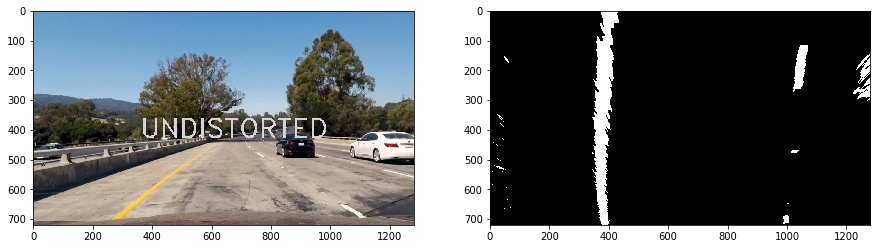

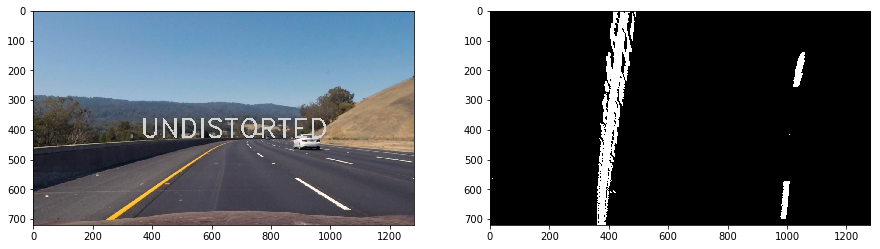

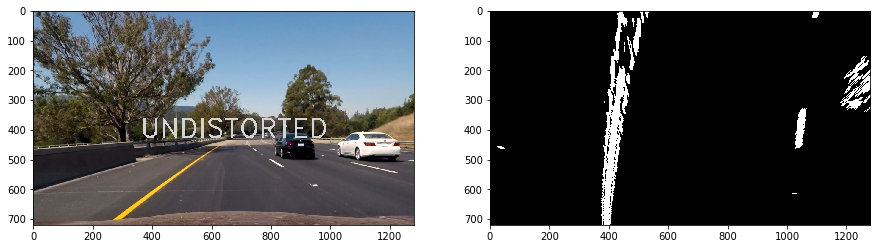

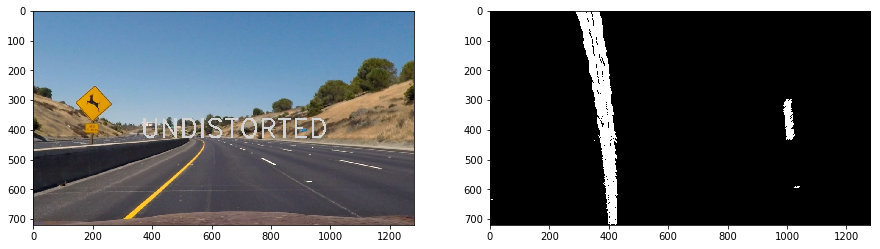

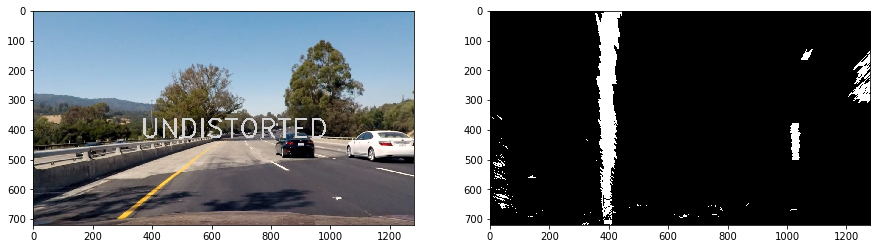

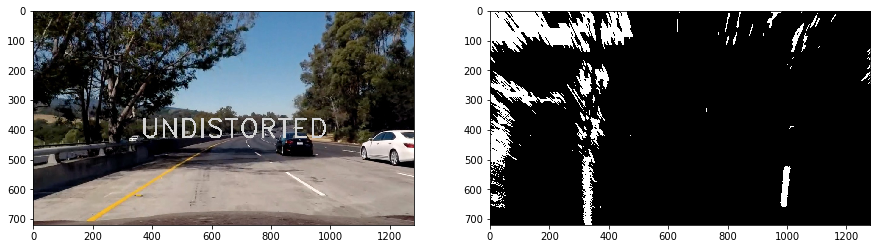

In [30]:
with open(os.path.join(repo_dir, 'data', 'calibration.p'),'rb') as f:
    calibration = pickle.load(f)

for path in glob.iglob(os.path.join(output_images_dir, './test[1-6].jpg')):
    img = mpimg.imread(path)
    birds_eye = run_pipeline(img, calibration['M'], calibration['dist'])

    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    axes[0].imshow(img)
    axes[1].imshow(birds_eye, cmap='gray')
    
    plt.show()
    plt.close(fig)